# Analysis of run741CU data

A quick exploratory analysis of rn741CU dataset obtained from Victor. 
Dataset URL https://checkpoint.url-protection.com/v1/url?o=http%3A//www.star.uclan.ac.uk/~vpd/4stefan.tar&g=MzEwMDg0NmNkODNjZGNhZg==&h=ZWNkMjFiZTZkOTY4NzJhY2Q5MDYwMWM2ZjAyMjE1YzVlODE4NmM5MGUyMzNhMDMxM2I3MmRlZjRhNGJkNGNlMw==&p=Y3AxZTp1Y2xhbmxpdmU6YzpvOjllYjJkY2RlMDRmZTYyNWExZjE0YmJhOWRhY2VlMjk2OnYxOmg6VA==

## Import modules and define functions

In [105]:
%matplotlib inline
import scipy
import pynbody as pb
from scipy import stats as st
from matplotlib.colors import LogNorm
from matplotlib.pylab import *

def pbload(filename, paramname=None):
    print('Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    print('Done!')
    return sim

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

base_dir = '/home/ubuntu/projects/S2B/shared/'
data_fname1 = base_dir + 'run741CU/run741CU.00500.gz'
data_fname2 = base_dir + 'run741CU/run741CU.01000.gz'
param_fname = base_dir + 'run741CU/run741CU.param'

## Load data

Loading a simulation output using the `pynbody.load()` function, which tries to automatically determine which type of code output you have:

In [61]:
s = pbload(data_fname1,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file...
Done!


Note that the above assumes you have downloaded and unpacked the test data in the above folder.

## Data exploration

In [5]:
s

<SimSnap "/home/ubuntu/projects/S2B/shared/run741CU/run741CU.00500" len=10000000>

In [3]:
len(s)

10000000

`stars`, `gas`, `dark` also available as `s`, `g`, `d`

In [7]:
len(s.star), len(s.gas), len(s.dark)

(6000000, 0, 4000000)

The `properties` attribute of a `SimSnap` tells us some more basic info 

In [8]:
s.properties

{'time': Unit("2.50e-05 kpc**3/2 G**-1/2 Msol**-1/2")}

In [9]:
s.properties['time'].in_units('Myr')

11.786978152775673

Which quantities do we have available?

In [10]:
s.keys()

[]

None! Because pynbody "lazy-loads" data... so lets see which data is actually on-disk:

In [11]:
s.loadable_keys()

['phi', 'vel', 'mass', 'pos', 'eps']

vel - velocity components vx, vy, vz - **km/s ?**, 
**phi - ?**, 
**eps - ?**, 
pos - position components x, y, z - kpc, 
mass - particle mass, **units?**

By default everything is in system units, but most of the time thinking in physical units is easier: But aparently there is no physical units defined in this dataset.

In [62]:
s.physical_units()

To access any of these arrays or vectors, you access them like a python dictionary: 

In [35]:
s.star['pos']

SimArray([[ 0.35583305,  4.08547497, -0.37093452],
          [ 0.48441628, -0.54632998,  0.23705608],
          [ 0.10476512, -3.03144145,  0.12226705],
          ...,
          [ 1.75160432,  6.71199369,  0.15174362],
          [-9.37289429, 10.85958004, -0.44605705],
          [10.69618893, -4.75199938, -0.03752042]], 'kpc')

Note that each array has units attached...

In [36]:
s.star['vel']

SimArray([[-22552.89859887, -23120.33491637,  -4764.34188211],
          [-13052.90714171,   8353.56025361,  19388.34132433],
          [ 26581.46718044,   1990.73143281,  12483.56496579],
          ...,
          [-21397.57971844,  11951.51875422,  -3064.73586252],
          [-35907.59751321, -28597.37014551,  -1970.06149227],
          [  9595.02330218,  39703.80801218,   -861.56163811]], 'km s**-1')

We have defined many useful quantities that are automatically calculated for you. For example, the radial and tangential velocities are simply obtained by

In [37]:
s.star['vt'],s.star['vr']

(SimArray([21624.71251085, 23429.01890165, 29428.80253425, ...,
           23936.74338035, 45907.93095353, 40189.52371876], 'km s**-1'),
 SimArray([-24459.22901991,  -8194.46193325,   -567.78936031, ...,
             6092.63002241,   1873.00727692,  -7348.55867184], 'km s**-1'))

We can try to access individual position and velocity components.

In [38]:
s.star['x'],s.star['y'],s.star['z']

(SimArray([ 0.35583305,  0.48441628,  0.10476512, ...,  1.75160432,
           -9.37289429, 10.69618893], 'kpc'),
 SimArray([ 4.08547497, -0.54632998, -3.03144145, ...,  6.71199369,
           10.85958004, -4.75199938], 'kpc'),
 SimArray([-0.37093452,  0.23705608,  0.12226705, ...,  0.15174362,
           -0.44605705, -0.03752042], 'kpc'))

In [39]:
s.star['vx'],s.star['vy'],s.star['vz']

(SimArray([-22552.89859887, -13052.90714171,  26581.46718044, ...,
           -21397.57971844, -35907.59751321,   9595.02330218], 'km s**-1'),
 SimArray([-23120.33491637,   8353.56025361,   1990.73143281, ...,
            11951.51875422, -28597.37014551,  39703.80801218], 'km s**-1'),
 SimArray([-4764.34188211, 19388.34132433, 12483.56496579, ...,
           -3064.73586252, -1970.06149227,  -861.56163811], 'km s**-1'))

## Working with density profiles

Text(0, 0.5, '$\\rho_{DM}$ [M$_{\\odot}$ kpc$^{-3}$]')

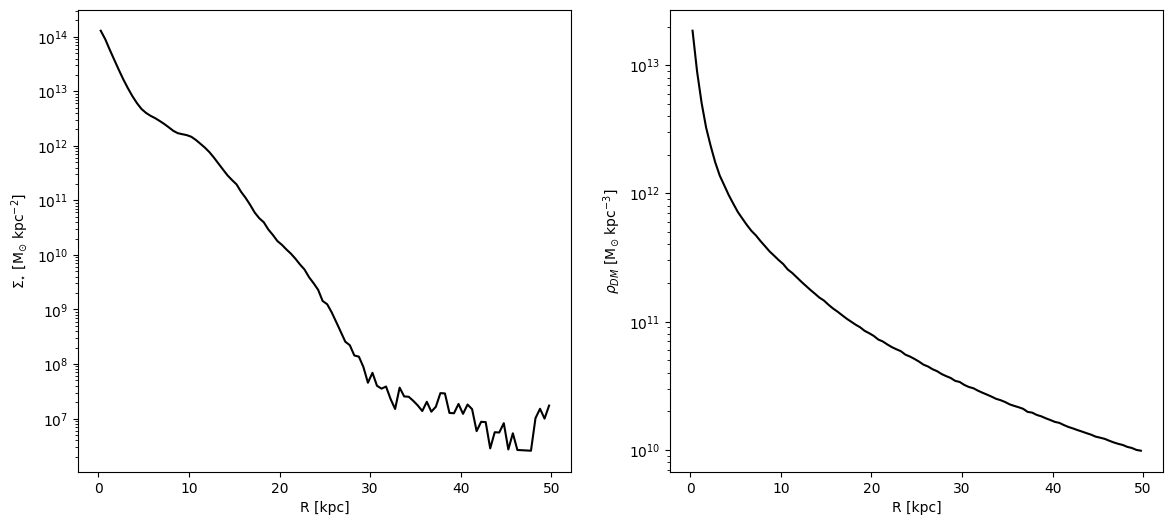

In [60]:
# center on the largest halo and align the disk
pb.analysis.angmom.faceon(s)

# convert all units to something reasonable (kpc, Msol etc)
s.physical_units()

# create a profile object for the stars (by default this is a 2D profile)
p = pb.analysis.profile.Profile(s.star, vmin =.01, max=50)

# Checking derivable keys
p.derivable_keys()

# make the figure and sub plots
f, axs = plt.subplots(1,2,figsize=(14,6))

# make the plot
axs[0].plot(p['rbins'],p['density'], 'k')
axs[0].semilogy()
axs[0].set_xlabel('R [kpc]')
axs[0].set_ylabel(r'$\Sigma_{\star}$ [M$_{\odot}$ kpc$^{-2}$]')

# make a 3D density plot of the dark matter (note ndim=3 in the constructor below)
p = pb.analysis.profile.Profile(s.dark,min=.01,max=50,ndim=3)

axs[1].plot(p['rbins'],p['density'], 'k')
axs[1].semilogy()
axs[1].set_xlabel('R [kpc]')
axs[1].set_ylabel(r'$\rho_{DM}$ [M$_{\odot}$ kpc$^{-3}$]')

## Rendering simple images with pynbody built-in functions

We render some simple images with pynbody image function, faceon, edgeon.

SimArray([[1.4944668e+10, 1.4382081e+10, 1.3819497e+10, ...,
           6.8274053e+09, 6.5399040e+09, 6.2524027e+09],
          [1.4452460e+10, 1.3765789e+10, 1.3079119e+10, ...,
           7.5602371e+09, 7.2703857e+09, 6.9805327e+09],
          [1.3960251e+10, 1.3149495e+10, 1.2338741e+10, ...,
           8.2930678e+09, 8.0008663e+09, 7.7086638e+09],
          ...,
          [5.8353992e+09, 5.7252234e+09, 5.6150477e+09, ...,
           3.6234975e+09, 3.4693064e+09, 3.3151150e+09],
          [6.2687089e+09, 5.9999068e+09, 5.7311037e+09, ...,
           3.5618493e+09, 3.3839557e+09, 3.2060621e+09],
          [6.7020191e+09, 6.2745897e+09, 5.8471613e+09, ...,
           3.5002012e+09, 3.2986051e+09, 3.0970089e+09]], dtype=float32, 'Msol kpc**-3')

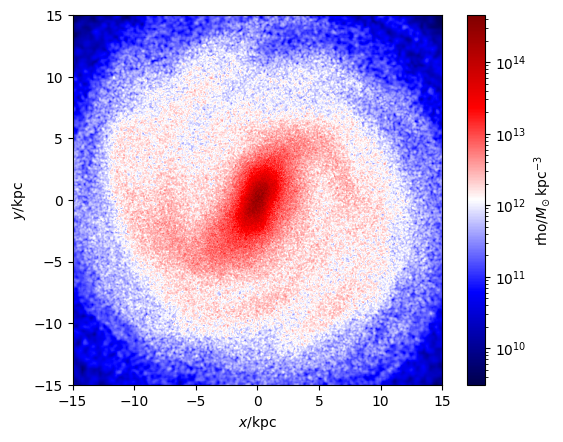

In [63]:
import pynbody.plot.sph as sph
cmap = 'seismic'

pb.analysis.angmom.faceon(s)
sph.image(s.star,qty="rho",width=30,cmap=cmap)

We see that the bar is almost aligned with the line of sight for edge-on.
Let us rotate 70 degrees clockwise about Z axis.

SimArray([[2.0640668e+10, 1.9939334e+10, 1.9238003e+10, ...,
           1.1515552e+10, 1.0835543e+10, 1.0155532e+10],
          [2.2523671e+10, 2.2436002e+10, 2.2348333e+10, ...,
           1.1428307e+10, 1.0951692e+10, 1.0475079e+10],
          [2.4406673e+10, 2.4932667e+10, 2.5458661e+10, ...,
           1.1341064e+10, 1.1067845e+10, 1.0794625e+10],
          ...,
          [1.4717223e+10, 1.5821825e+10, 1.6926429e+10, ...,
           8.9527091e+09, 9.6255795e+09, 1.0298451e+10],
          [1.4437092e+10, 1.5872108e+10, 1.7307126e+10, ...,
           8.3293880e+09, 8.8637164e+09, 9.3980447e+09],
          [1.4156961e+10, 1.5922390e+10, 1.7687820e+10, ...,
           7.7060664e+09, 8.1018527e+09, 8.4976389e+09]], dtype=float32, 'Msol kpc**-3')

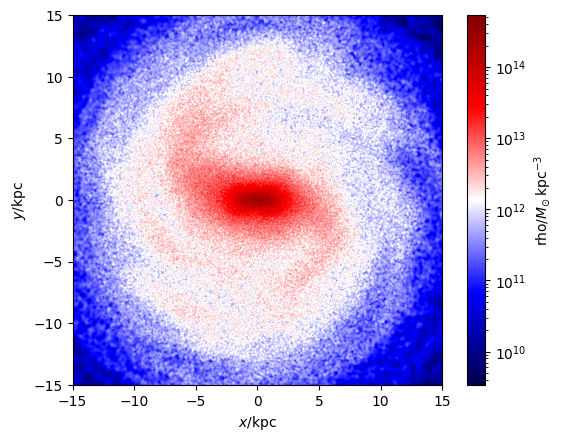

In [64]:
s.rotate_z(-70)
sph.image(s.star,qty="rho",width=30,cmap=cmap)

Let us rotate 90 clockwise about X axis to get an edge-on view.

SimArray([[2.2002317e-27, 2.0766222e-27, 1.9530128e-27, ...,
           6.8794014e-26, 6.9176920e-26, 6.9559832e-26],
          [2.2356836e-27, 2.1100319e-27, 1.9843808e-27, ...,
           7.0476673e-26, 7.0853866e-26, 7.1231058e-26],
          [2.2711352e-27, 2.1434420e-27, 2.0157486e-27, ...,
           7.2159344e-26, 7.2530805e-26, 7.2902272e-26],
          ...,
          [6.6072617e-27, 6.6366437e-27, 6.6660272e-27, ...,
           2.1623514e-26, 2.1287929e-26, 2.0952346e-26],
          [6.2531710e-27, 6.2823403e-27, 6.3115101e-27, ...,
           2.1325422e-26, 2.0988324e-26, 2.0651226e-26],
          [5.8990803e-27, 5.9280363e-27, 5.9569930e-27, ...,
           2.1027328e-26, 2.0688718e-26, 2.0350109e-26]], dtype=float32, 'g cm**-3')

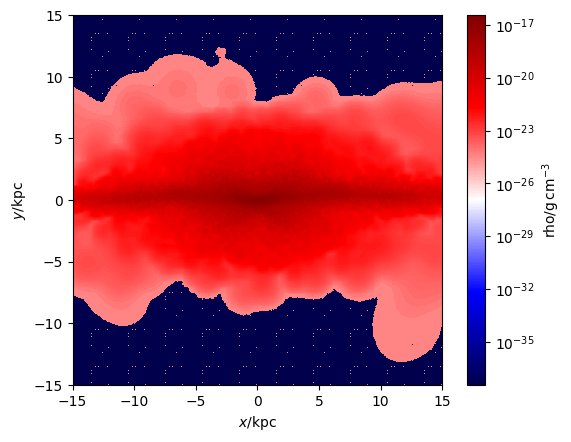

In [65]:
s.rotate_x(-90)
sph.image(s.star,qty="rho",units='g cm^-3',width=30,cmap=cmap)

## Bar angle 0 - binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [70]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname2,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run741CU/run741CU.01000.gz ...
Done!


In [71]:
# Define global variables

bins = 100
xlim, ylim = 25, 25
cmap = 'seismic'

#### Face-on number density

Rotate to 70 or 10 degrees clockwise about Z axis to allign the bar.
Calculate the binned 2d statisticss for number densities and plot face-on view.
Plot the grid to visually confirm the bar alignment.

In [73]:
# s.rotate_z(-70) # 00500 dataset
s.rotate_z(-10) # 01000 dataset

/tmp/ipykernel_222/337195252.py:23: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


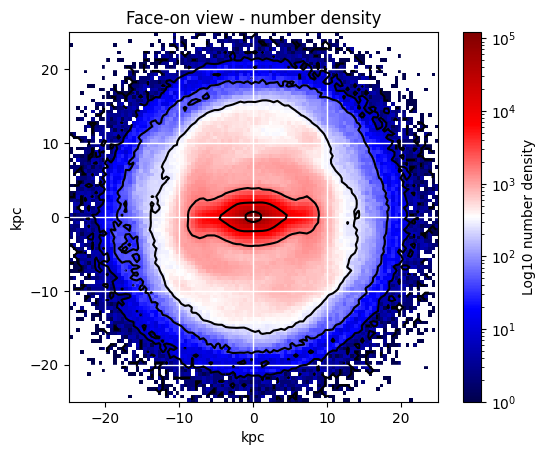

In [74]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Face-on view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
axes.grid(color='w', linestyle='-', linewidth=1)

'''
#calculate equation for trendline
zz = np.polyfit(s.star['x'], s.star['y'], 1)
pp = np.poly1d(zz)

#add trendline to plot
plt.plot(s.star['x'], pp(s.star['x']),color="w", linewidth=1, linestyle="-")
'''
plt.show()


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [75]:
s.rotate_x(-60)

/tmp/ipykernel_222/3799049574.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


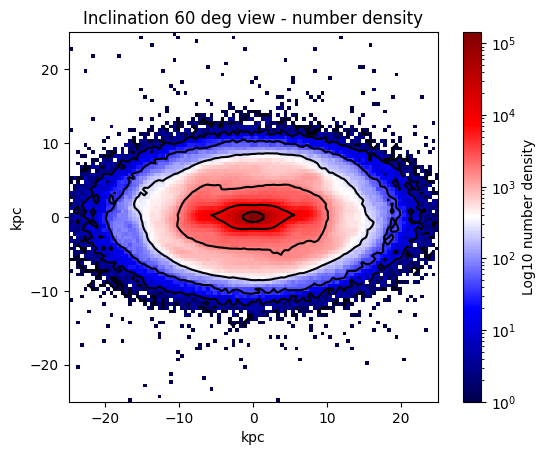

In [76]:
# Zoom in
# xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [77]:
s.rotate_x(-30)

/tmp/ipykernel_222/4228707543.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


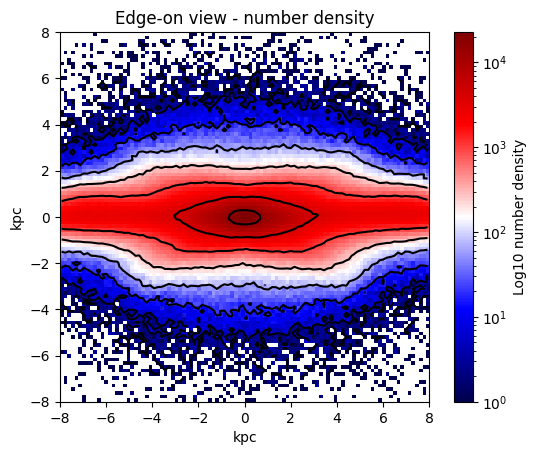

In [78]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


### Velocity distribution

#### Load data

In [93]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname2,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run741CU/run741CU.01000.gz ...
Done!


/home/ubuntu/.local/lib/python3.10/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


#### Basic velocity distribution histograms

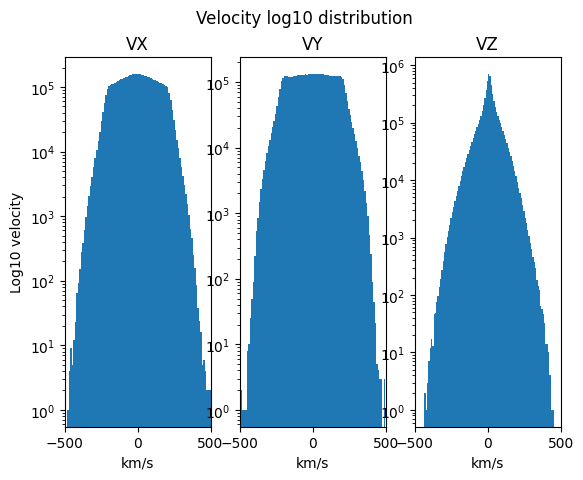

In [31]:
# Extracting position and velocity components

x = s.star['pos'][:,0]
y = s.star['pos'][:,1]
z = s.star['pos'][:,2]
vx = s.star['vel'][:,0]
vy = s.star['vel'][:,1]
vz = s.star['vel'][:,2]

x_lim = 500
bins = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Velocity log10 distribution')
ax1.hist(vx, log = True, bins = bins)
ax1.set_title('VX')
ax1.set_xlim(-x_lim, x_lim)
ax1.set_xlabel('km/s')
ax1.set_ylabel('Log10 velocity')
ax2.hist(vy, log = True, bins = bins)
ax2.set_title('VY')
ax2.set_xlim(-x_lim, x_lim)
ax2.set_xlabel('km/s')
ax3.hist(vz, log = True, bins = bins)
ax3.set_title('VZ')
ax3.set_xlim(-x_lim, x_lim)
ax3.set_xlabel('km/s')
plt.show()

#### Face-on - mean velocity

In [94]:
# s.rotate_z(-70)
s.rotate_z(-10)

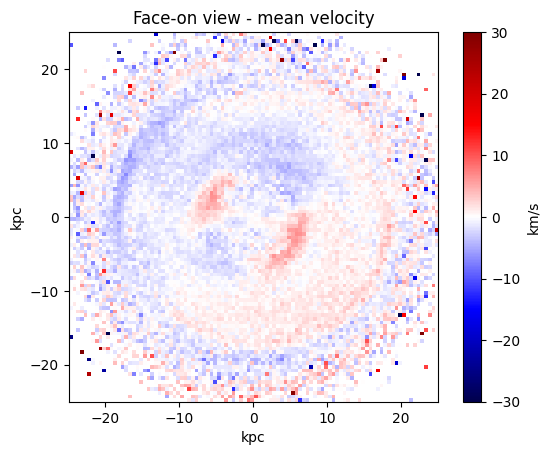

In [95]:
# Zoom out
xlim, ylim = 25, 25

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Face-on view - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Face-on - velocity dispersion

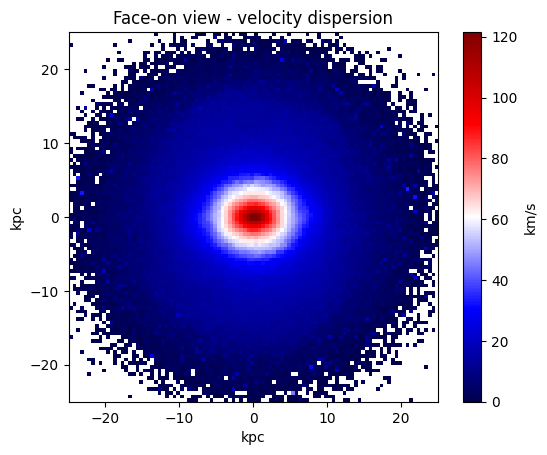

In [96]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Inclination 60 deg - mean velocity

In [97]:
s.rotate_x(-60)

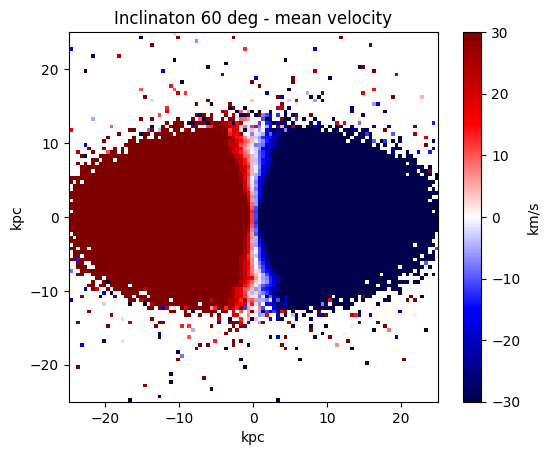

In [98]:
# Zoom out
xlim, ylim = 25, 25

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Inclinaton 60 deg - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Inclination 60 deg - velocity dispersion

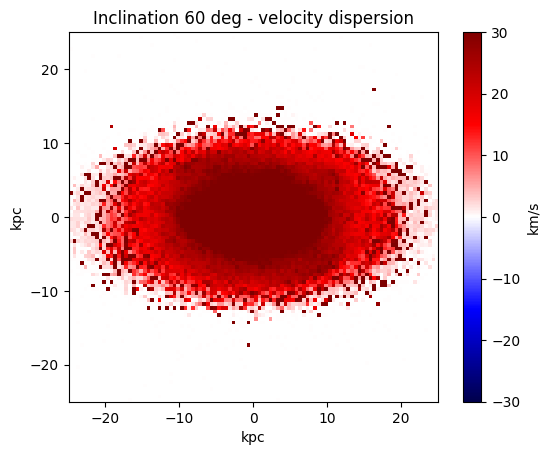

In [99]:
# Zoom out
xlim, ylim = 25, 25

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Inclination 60 deg - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [100]:
s.rotate_x(-30)

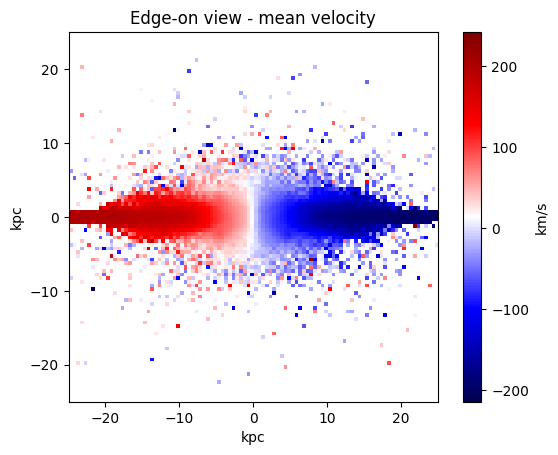

In [101]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Edge-on view - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - velocity dispersion

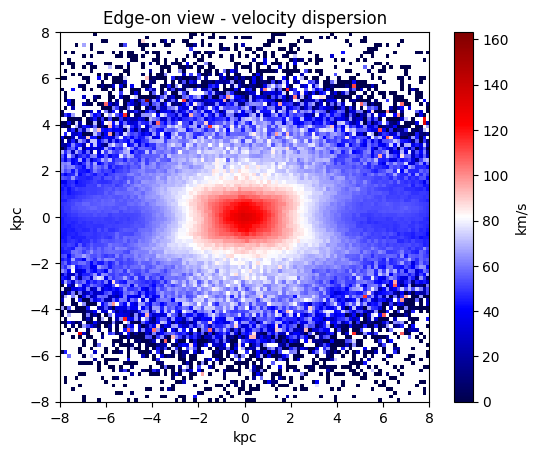

In [102]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - h3

/tmp/ipykernel_222/3465329135.py:27: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
/tmp/ipykernel_222/3465329135.py:27: RuntimeWarning: invalid value encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


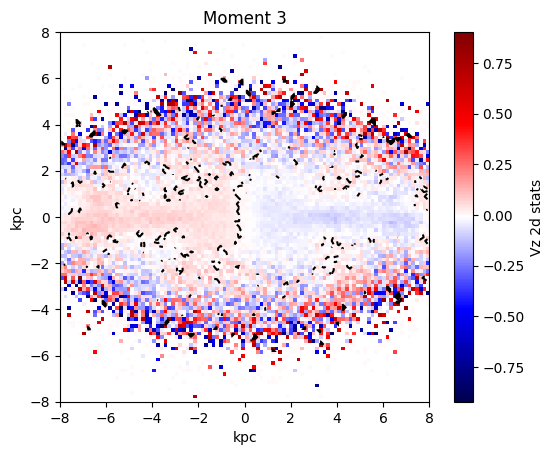

In [103]:
# Zoom in
xlim, ylim = 8, 8

m = 3

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Moment 3'
cbar_label = 'Vz 2d stats'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - h4

/tmp/ipykernel_222/2533639094.py:27: RuntimeWarning: invalid value encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


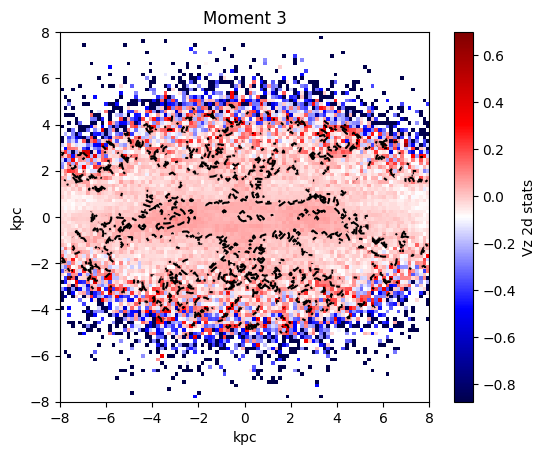

In [104]:
# Zoom in
xlim, ylim = 8, 8

m = 4

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Moment 3'
cbar_label = 'Vz 2d stats'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

## Bar angle 45 - binned 2d-statistics for number density and velocity

### Number density

#### Load data

In [45]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname1,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run741CU/run741CU.00500.gz ...
Done!


/home/ubuntu/.local/lib/python3.10/site-packages/pynbody/snapshot/tipsy.py:124: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


In [46]:
# Define global variables.

bins = 100
xlim, ylim = 25, 25
cmap = 'seismic'

#### Face-on number density

Rotate to 25 degree clockwise about Z axis to bar have the bar angle 45.
Calculate the binned 2d statisticss for number densities and plot face-on view.
Plot the grid to visually confirm the bar alignment.

In [47]:
s.rotate_z(-25)

/tmp/ipykernel_222/1822298016.py:23: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


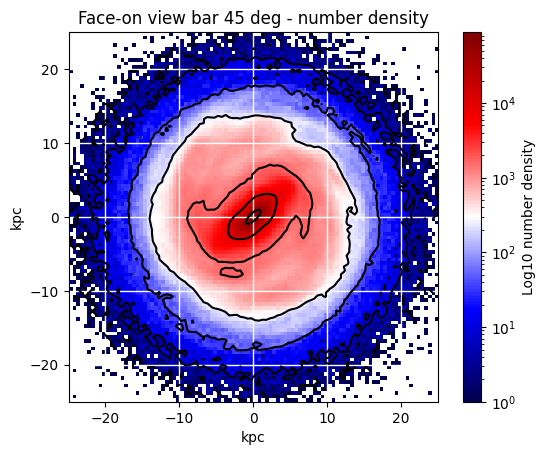

In [48]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Face-on view bar 45 deg - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
axes.grid(color='w', linestyle='-', linewidth=1)

'''
#calculate equation for trendline
zz = np.polyfit(s.star['x'], s.star['y'], 1)
pp = np.poly1d(zz)

#add trendline to plot
plt.plot(s.star['x'], pp(s.star['x']),color="w", linewidth=1, linestyle="-")
'''
plt.show()


#### Inclination 60 deg - number density

Rotate 60 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [49]:
s.rotate_x(-60)

/tmp/ipykernel_222/3799049574.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


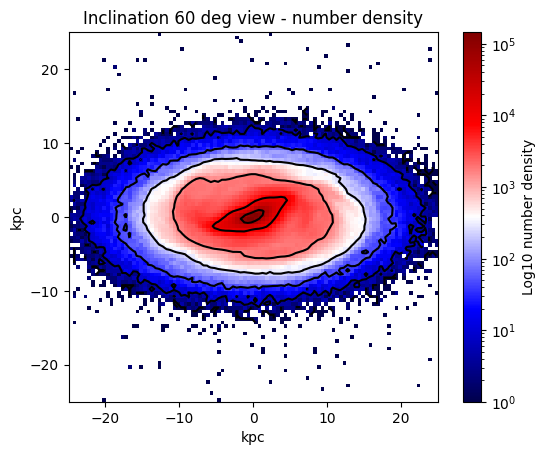

In [50]:
# Zoom in
# xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Inclination 60 deg view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - number density

Rotate 60 + 30 = 90 degrees clockwise about X axis for edge-on view.
Calculate the binned 2d statistics and plot.

In [51]:
s.rotate_x(-30)

/tmp/ipykernel_222/4228707543.py:26: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


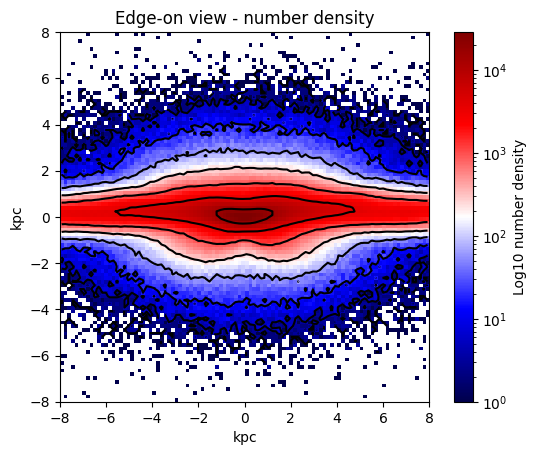

In [52]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                              statistic = 'count',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    norm = LogNorm(),
                    cmap=cmap)

plt_title = 'Edge-on view - number density'
cbar_label = 'Log10 number density'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


### Velocity distribution

#### Load data

In [53]:
# We reload the data to drop effects of prevous manipulations and centre it for face-on view.

s = pbload(data_fname1,param_fname)
pb.analysis.angmom.faceon(s)

Loading data from file /home/ubuntu/projects/S2B/shared/run741CU/run741CU.00500.gz ...
Done!


#### Basic velocity distribution histograms

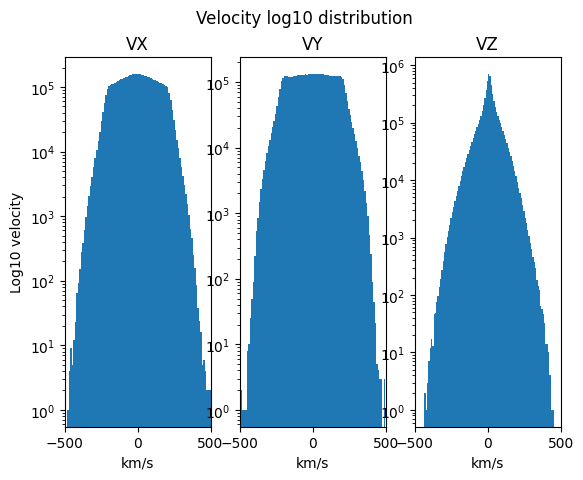

In [22]:
# Extracting position and velocity components

x = s.star['pos'][:,0]
y = s.star['pos'][:,1]
z = s.star['pos'][:,2]
vx = s.star['vel'][:,0]
vy = s.star['vel'][:,1]
vz = s.star['vel'][:,2]

x_lim = 500
bins = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Velocity log10 distribution')
ax1.hist(vx, log = True, bins = bins)
ax1.set_title('VX')
ax1.set_xlim(-x_lim, x_lim)
ax1.set_xlabel('km/s')
ax1.set_ylabel('Log10 velocity')
ax2.hist(vy, log = True, bins = bins)
ax2.set_title('VY')
ax2.set_xlim(-x_lim, x_lim)
ax2.set_xlabel('km/s')
ax3.hist(vz, log = True, bins = bins)
ax3.set_title('VZ')
ax3.set_xlim(-x_lim, x_lim)
ax3.set_xlabel('km/s')
plt.show()

#### Face-on - mean velocity

Rorate 25 degrees clockwise about Z axis for bar angle 45.

In [54]:
s.rotate_z(-25)

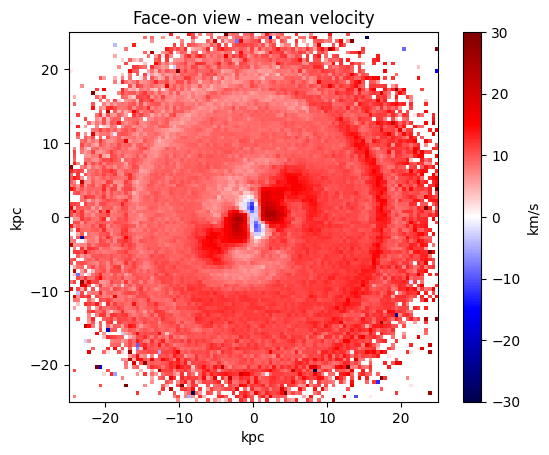

In [55]:
# Zoom out
xlim, ylim = 25, 25

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Face-on view - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)
plt.clim(-30,30)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Face-on - velocity dispersion

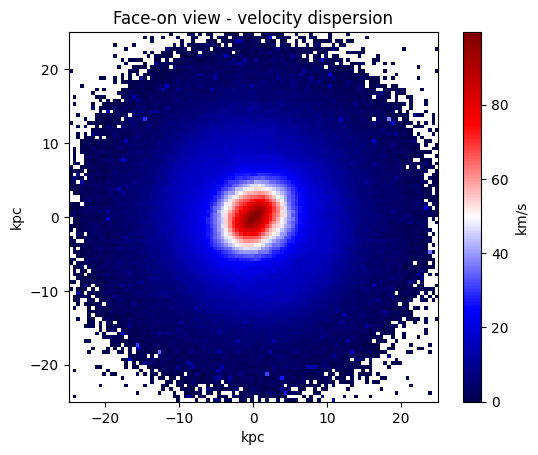

In [56]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Face-on view - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Inclination 60 deg - mean velocity

Rotate 60 degrees clockwise about X axis.
Calculate the binned velocity 2d statistics and plot.

In [57]:
s.rotate_x(-60)

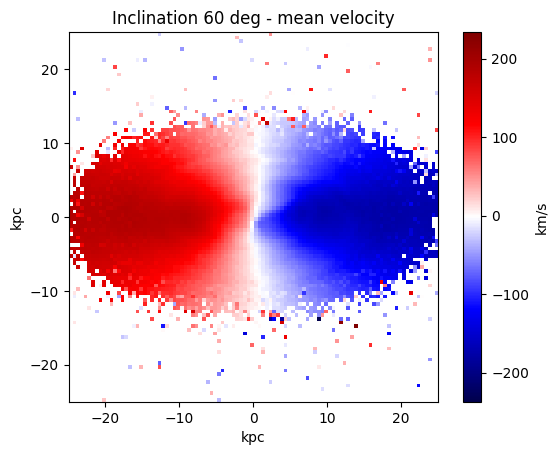

In [59]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Inclination 60 deg - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Inclination 60 - velocity dispersion

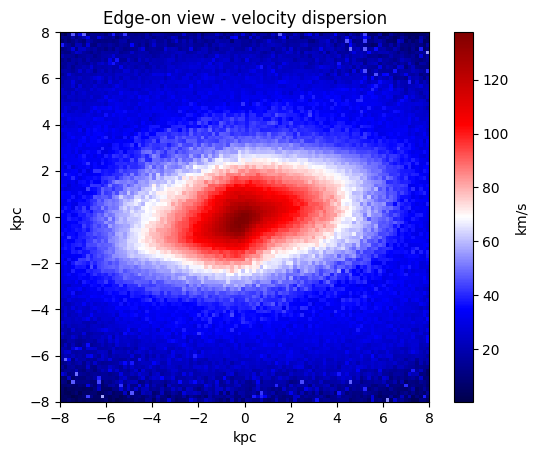

In [60]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - mean velocity

Rotate 90 degrees clockwise about X axis for edge-on view.
Calculate the binned velocity 2d statistics and plot.

In [61]:
s.rotate_x(-30)

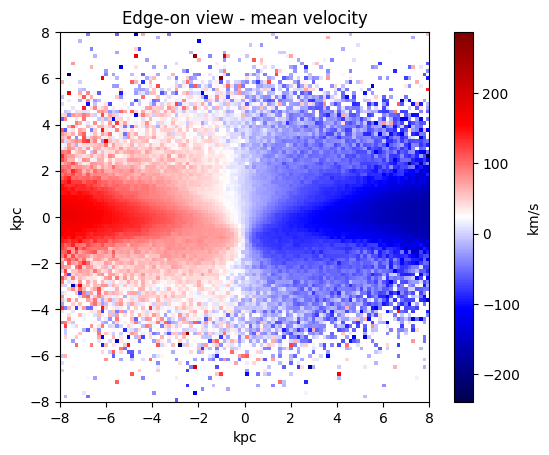

In [62]:
stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'mean',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Edge-on view - mean velocity'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - velocity dispersion

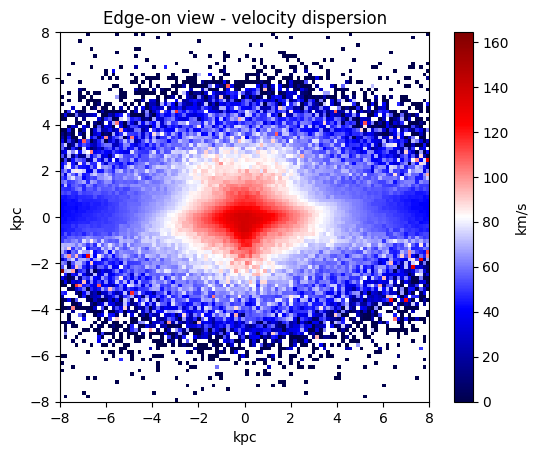

In [63]:
# Zoom in
xlim, ylim = 8, 8

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = 'std',
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Edge-on view - velocity dispersion'
cbar_label = 'km/s'

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()


#### Edge-on - h3

/tmp/ipykernel_222/3465329135.py:27: RuntimeWarning: divide by zero encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
/tmp/ipykernel_222/3465329135.py:27: RuntimeWarning: invalid value encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


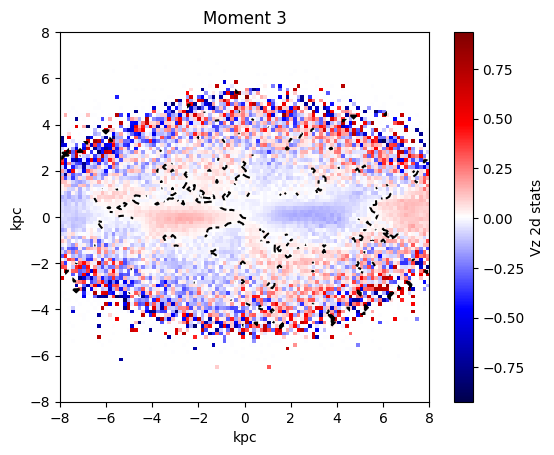

In [64]:
# Zoom in
xlim, ylim = 8, 8

m = 3

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Moment 3'
cbar_label = 'Vz 2d stats'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()

#### Edge-on - h4

/tmp/ipykernel_222/2533639094.py:27: RuntimeWarning: invalid value encountered in log10
  axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')


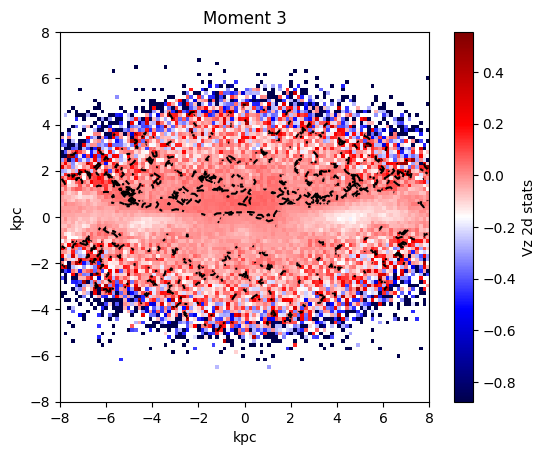

In [65]:
# Zoom in
xlim, ylim = 8, 8

m = 4

stat2d,xedges,yedges,binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                              statistic = lambda bin_values: GaussHermiteMoment(bin_values, m),
                              range = [[-xlim,xlim],[-ylim,ylim]],
                              bins = bins)

image = plt.imshow(stat2d.T, 
                    origin = 'lower',
                    extent = [-xlim, xlim, -ylim, ylim ],
                    cmap=cmap)

plt_title = 'Moment 3'
cbar_label = 'Vz 2d stats'

xcent = (xedges[1:] + xedges[:-1]) / 2
ycent = (yedges[1:] + yedges[:-1]) / 2

plt.title(plt_title)  
cbar = plt.colorbar()
cbar.set_label(cbar_label)
axes = plt.gca()
axes.set_aspect(1)
axes.contour(xcent, ycent, np.log10(stat2d.T), colors='k')
axes.set_xlabel('kpc')
axes.set_ylabel('kpc')
axes.set_xlim(-xlim, xlim)
axes.set_ylim(-ylim, ylim)
plt.show()